In [50]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

In [51]:
train = pd.read_csv('../data/train_features.csv')
test = pd.read_csv('../data/test_features.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (5304, 6)
Test set shape: (22660, 6)


,ID,class_index1,class_index2,euclidean_similarity,cosine_similarity,is_same
0,0,818,598,31.187445,0.739631,0
1,1,811,811,0.000000,1.000000,1
2,2,897,651,28.852077,0.753822,0
3,3,421,421,7.317266,0.984405,1
4,4,538,538,0.000000,1.000000,1


In [52]:
train.head()
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
ID                      0
class_index1            0
class_index2            0
euclidean_similarity    0
cosine_similarity       0
is_same                 0
dtype: int64

TEST SET MISSING VALUES:
ID                      0
class_index1            0
class_index2            0
euclidean_similarity    0
cosine_similarity       0
sift                    0
dtype: int64


In [53]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100 * train.duplicated().sum() / len(train), 1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100 * test.duplicated().sum() / len(test),  1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


In [54]:
train.nunique()

ID                      5304
class_index1             156
class_index2             153
euclidean_similarity    4951
cosine_similarity       4943
is_same                    2
dtype: int64

In [55]:
train.dtypes

ID                        int64
class_index1              int64
class_index2              int64
euclidean_similarity    float64
cosine_similarity       float64
is_same                   int64
dtype: object

Text(0.5, 1.0, 'Target distribution')

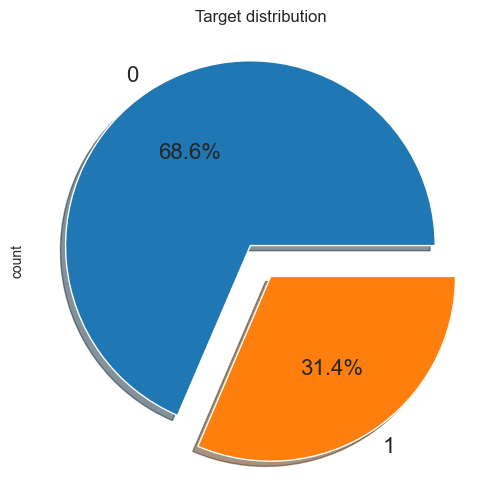

In [56]:
# Figure size
plt.figure(figsize=(6, 6))

# Pie plot
train['is_same'].value_counts().plot.pie(explode=[0.1, 0.1],
                                             autopct='%1.1f%%',
                                             shadow=True,
                                             textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 1.0, 'euclidean similarity distribution')

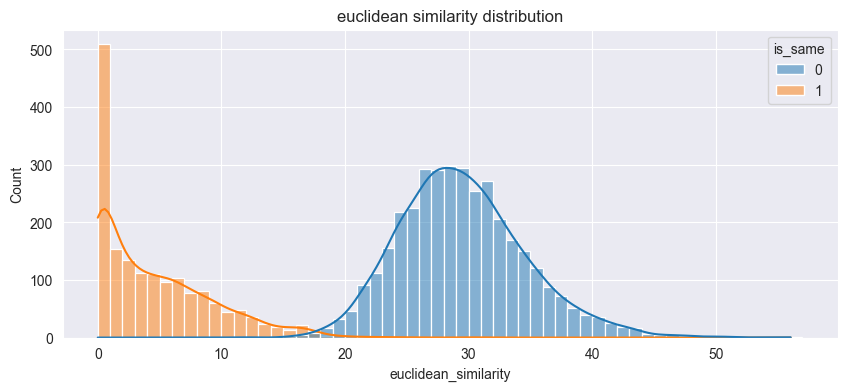

In [57]:
# Figure size
plt.figure(figsize=(10, 4))

# Histogram
sns.histplot(data=train, x='euclidean_similarity', hue='is_same', binwidth=1, kde=True)

# Aesthetics
plt.title('euclidean similarity distribution')

Text(0.5, 1.0, 'cosine similarity distribution')

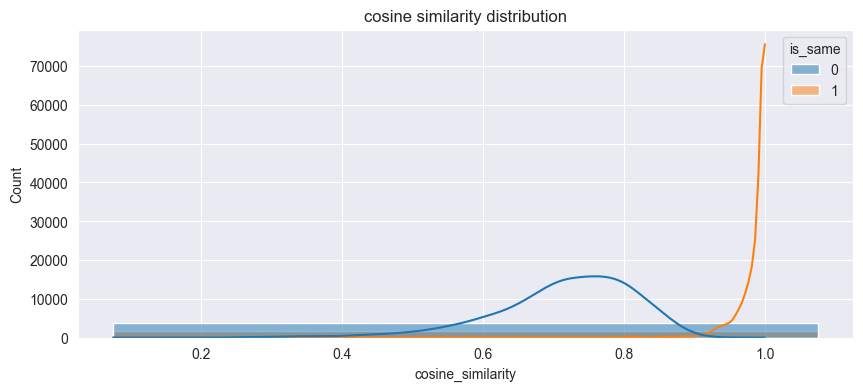

In [58]:
# Figure size
plt.figure(figsize=(10, 4))

# Histogram
sns.histplot(data=train, x='cosine_similarity', hue='is_same', binwidth=1, kde=True)

# Aesthetics
plt.title('cosine similarity distribution')

In [59]:
y = train['is_same']
X = train[['class_index1', 'class_index2', 'euclidean_similarity', 'cosine_similarity']]

X_test = test[['class_index1', 'class_index2', 'euclidean_similarity', 'cosine_similarity']]


numerical_cols = [cname for cname in X_test.columns if X_test[cname].dtype in ['int64', 'float64']]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0)

In [61]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [62]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifier':classifiers.keys(),
                            'Validation accuracy': np.zeros(len(classifiers)),
                            'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)

    clf_best_params[key] = clf.best_params_

    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start) / 60, 2)

    print('Model:', key)
    print('Training time (minutes):', valid_scores.iloc[i, 2])
    print('')
    i += 1

Model: LogisticRegression
Training time (minutes): 0.07

Model: SVC
Training time (minutes): 0.06

Model: RandomForest
Training time (minutes): 0.46

Model: XGBoost
Training time (minutes): 0.22

Model: LGBM
Training time (minutes): 0.1

Model: NaiveBayes
Training time (minutes): 0.0



In [63]:
valid_scores

,Classifier,Validation accuracy,Training time
0,LogisticRegression,0.995287,0.07
1,SVC,0.997172,0.06
2,RandomForest,0.996230,0.46
3,XGBoost,0.996230,0.22
4,LGBM,0.994345,0.10
5,NaiveBayes,0.991517,0.00


In [64]:
clf_best_params

{'LogisticRegression': {'C': 1.5, 'max_iter': 50},
 'SVC': {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 4, 'n_estimators': 150},
 'XGBoost': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150},
 'NaiveBayes': {'var_smoothing': 1e-10}}

In [65]:
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "XGBoost" : XGBClassifier(**clf_best_params["XGBoost"], random_state=0),
}

In [69]:
def train(folds: int = 5):
    for _, clf in best_classifiers.items():
        score = 0
        start = time.time()

        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_train, X_valid = X[train_idx], X[val_idx]
            y_train, y_valid = y[train_idx], y[val_idx]

            clf.fit(X_train, y_train)
            score += clf.score(X_valid, y_valid)

        stop = time.time()
        score = score / folds

        print('Model:', key)
        print('Average validation accuracy:', np.round(100 * score, 2))
        print('Training time (minutes):', np.round((stop - start) / 60, 2))

In [70]:
train()

Model: NaiveBayes
Average validation accuracy: 99.57
Training time (minutes): 0.02
Model: NaiveBayes
Average validation accuracy: 99.64
Training time (minutes): 0.03


[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=0, ...)]

In [77]:
def test():
    for key, classifier in best_classifiers.items():
        predictions = np.zeros(len(X_valid))
        predictions += classifier.predict_proba(X_valid)[:, 1]

    predictions = predictions / len(best_classifiers)

    return predictions

In [78]:
valid_predictions = test()

In [86]:
cm = confusion_matrix(y_valid, valid_predictions > 0.5)

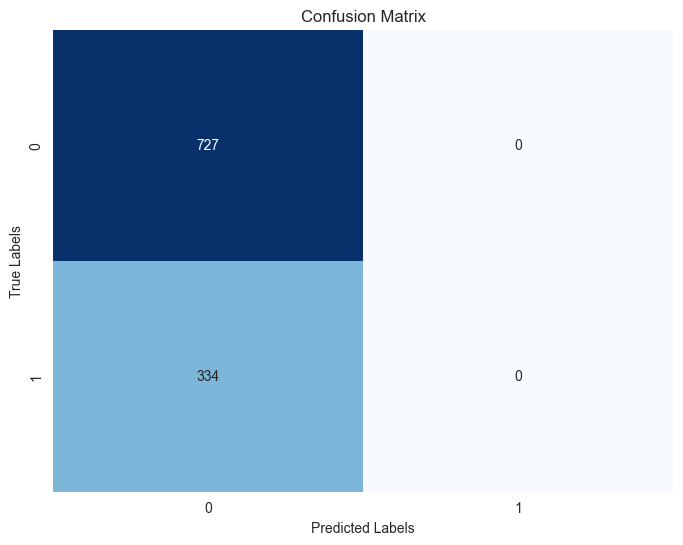

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [93]:
report = classification_report(y_valid, valid_predictions > 0.5)
print(report)

              precision    recall  f1-score   support

           0       0.69      1.00      0.81       727
           1       0.00      0.00      0.00       334

    accuracy                           0.69      1061
   macro avg       0.34      0.50      0.41      1061
weighted avg       0.47      0.69      0.56      1061



/Users/tylerdurden/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerdurden/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerdurden/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier